In [103]:
import pandas as pd
import xgboost as xgb
import numpy as np
import plotly.express as px
import seaborn as sns
import squarify
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

각 파일 불러오기

In [104]:
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

기간 별 주문 현황

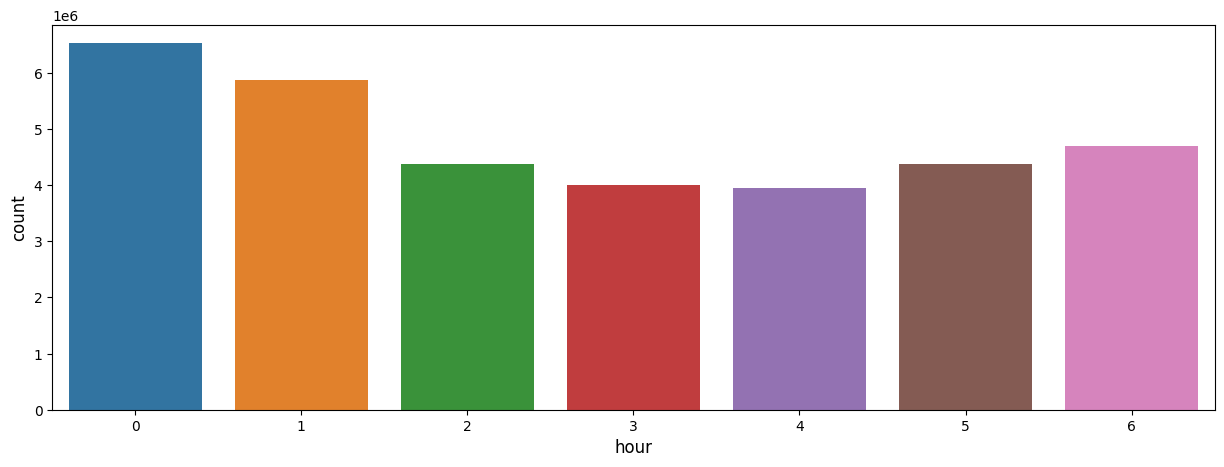

In [3]:
#분석에 필요한 df 생성
order_prior_id = order_products_prior[['order_id', 'product_id']]
order_train_id = order_products_train[['order_id', 'product_id']]
orders_date = orders[['order_id','order_dow', 'order_hour_of_day']]
product_id = products[['product_id', 'product_name']]

#신규 df merge
order_products = pd.concat([order_prior_id, order_train_id], axis=0)
merged_data = order_products.merge(orders_date, on='order_id', how='left').merge(product_id, on='product_id', how='left')

#요일 별 주문 건수 시각화
plt.figure(figsize=(15, 5))
sns.countplot(x="order_dow", data=merged_data)

plt.xlabel('hour', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.show()

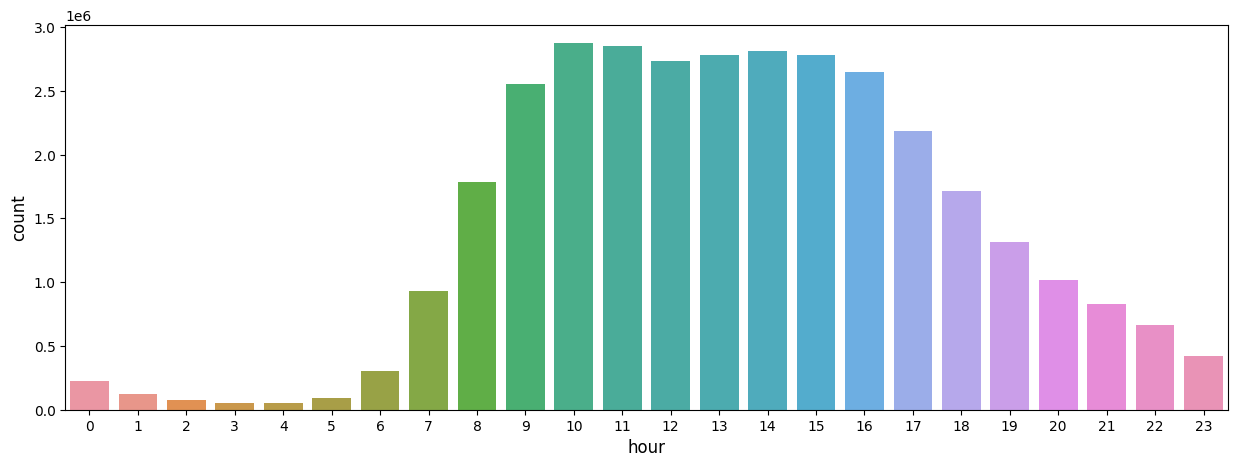

In [4]:
#시간대 별 주문량 추이
plt.figure(figsize=(15, 5))
sns.countplot(x="order_hour_of_day", data=merged_data)

plt.xlabel('hour', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.show()

aisle별 가장 많이 구매한 제품 현황

In [38]:
# order_products_prior와 order_products_train 데이터 합치기
selected_data = pd.concat([order_products_prior[['order_id', 'product_id']], order_products_train[['order_id', 'product_id']]], axis=0)

In [39]:
product_counts = selected_data['product_id'].value_counts().reset_index()
product_counts.columns = ['product_id', 'count']
result = pd.merge(product_counts, products[['product_id', 'product_name', 'aisle_id']], on='product_id', how='left')
result = pd.merge(result, aisles[['aisle_id', 'aisle']], on='aisle_id', how='left')
top_aisles = result.groupby('aisle').sum().nlargest(10, 'count').index.tolist()

In [6]:
selected_data# 각 'aisle' 내에서 상위 10개의 'product' 선택
top_products_in_aisle = {}
for aisle in top_aisles:
    top_products = result[result['aisle'] == aisle].nlargest(10, 'count')
    top_products_in_aisle[aisle] = top_products
final = pd.concat([top_products_in_aisle[aisle] for aisle in top_aisles])

#트리맵그리기
# Create the label column with product_name and count
final['label'] = final['product_name'] + ' (' + final['count'].astype(str) + ')'
# Replace spaces with line breaks in the label
final['label'] = final['label'].str.replace(' ', '<br>')

# Create the treemap using plotly with adjusted text font size
fig = px.treemap(final, path=['aisle', 'label'], values='count',
                 title='Top Products in Top Aisles',
                 color_discrete_sequence=px.colors.qualitative.Set3)

# Adjust font size
fig.update_traces(textfont_size=14)

# Display the treemap with modified labels
fig.show()

회당 구매 제품 개수 현황

count    3346083.00
mean          10.11
std            7.54
min            1.00
25%            5.00
50%            8.00
75%           14.00
max          145.00
dtype: float64


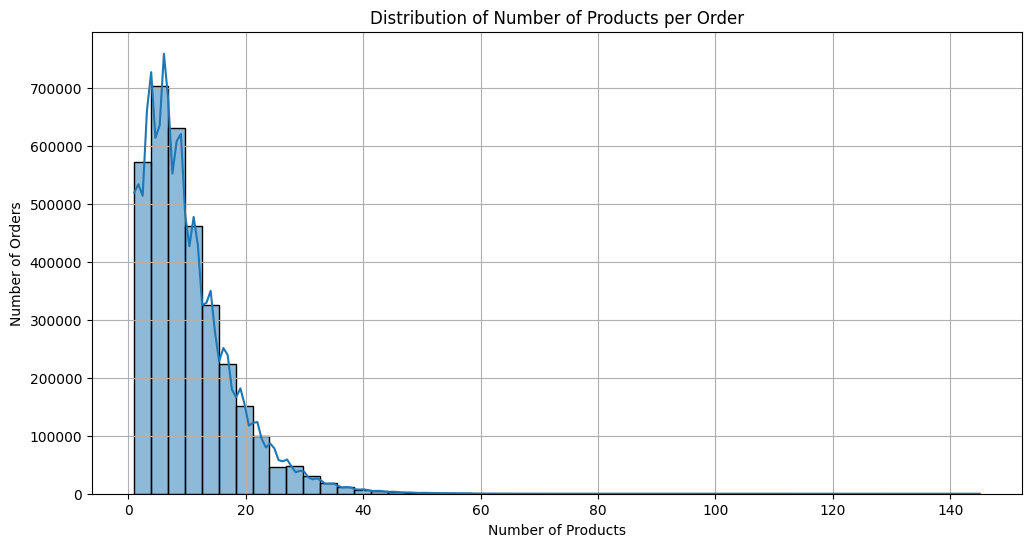

In [7]:
order_product_counts = selected_data.groupby('order_id').size()

order_product_counts_description = order_product_counts.describe().apply(lambda x: round(x, 2))

print(order_product_counts_description)

# 기초 통계치 확인
stats = order_product_counts.describe()

# 히스토그램으로 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(order_product_counts, bins=50, kde=True)
plt.title('Distribution of Number of Products per Order')
plt.xlabel('Number of Products')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


제품 구매 추이 - 동시 주문 제품 현황

In [10]:
# 상위 100개 제품의 ID 목록 추출
top_100_products = selected_data['product_id'].value_counts().head(100).index

# 상위 100개 제품에 대한 데이터만 필터링
filtered_data = selected_data[selected_data['product_id'].isin(top_100_products)]

# one-hot encoding 진행
basket_top100 = (filtered_data.groupby(['order_id', 'product_id'])
                .size().unstack().reset_index().fillna(0)
                .set_index('order_id'))

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

# 0과 1로 변환
basket_sets_top100 = basket_top100.applymap(encode_units)

# Apriori 알고리즘 적용
frequent_itemsets = apriori(basket_sets_top100.astype(bool), min_support=0.01, use_colnames=True)

# 연관 규칙 분석
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

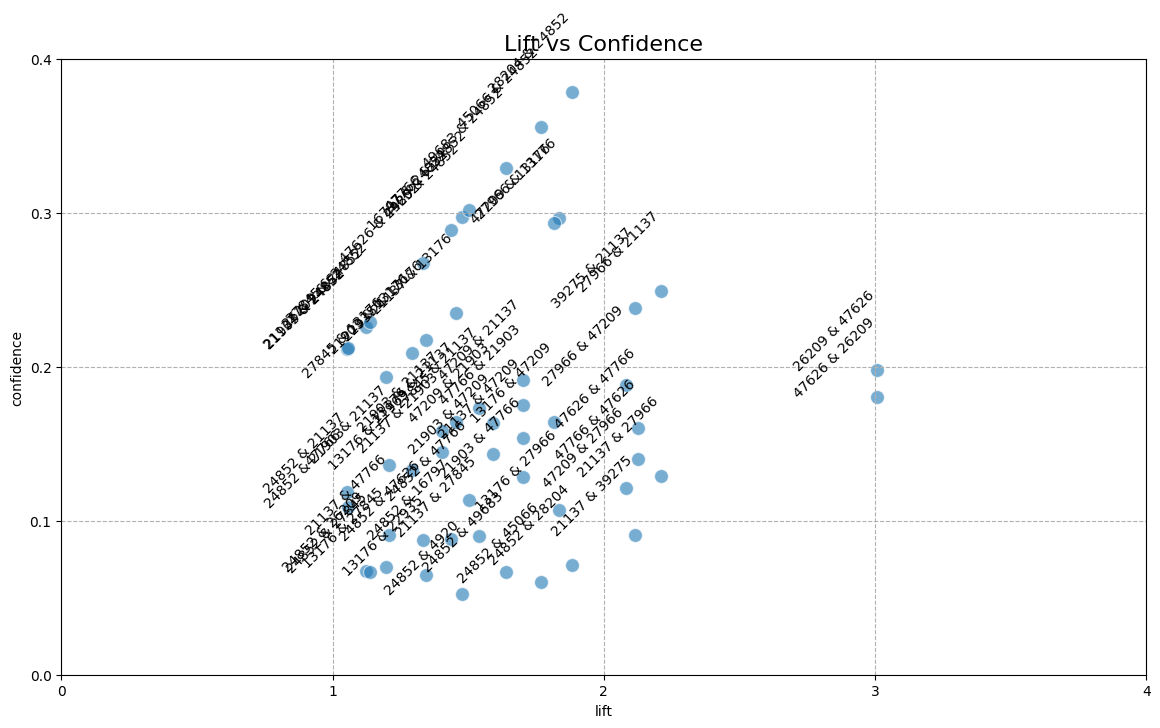

In [11]:
# Lift와 Confidence를 기준으로 scatter plot 그리기
product_name_mapping = dict(zip(products.product_id, products.product_name))

plt.figure(figsize=(14, 8))
sns.scatterplot(data=rules, x="lift", y="confidence", alpha=0.6, edgecolor='w', s=100)
plt.title("Lift vs Confidence", fontsize=16)
plt.yticks(np.arange(0, 0.5, 0.1))
plt.xticks(np.arange(0, rules["lift"].max()+1, 1))
plt.grid(True, linestyle='--')

# 상위 10개의 규칙에 대한 텍스트 표시
top_rules = rules.nlargest(10, 'lift')
for i, row in rules.iterrows():
    plt.text(row['lift'], row['confidence'], f"{list(row['antecedents'])[0]} & {list(row['consequents'])[0]}", 
             rotation=45, horizontalalignment='right')
plt.show()



결과 전체 보기

In [12]:
sorted_data = rules.sort_values(by='lift', ascending=False)
sorted_data

antecedents consequents  antecedent support  consequent support   support  \
51     (47626)     (26209)            0.065764            0.059984  0.011860   
50     (26209)     (47626)            0.059984            0.065764  0.011860   
23     (27966)     (21137)            0.058325            0.112711  0.014533   
22     (21137)     (27966)            0.112711            0.058325  0.014533   
55     (47766)     (47626)            0.075348            0.065764  0.010538   
54     (47626)     (47766)            0.065764            0.075348  0.010538   
25     (39275)     (21137)            0.042956            0.112711  0.010235   
24     (21137)     (39275)            0.112711            0.042956  0.010235   
53     (27966)     (47209)            0.058325            0.090339  0.010966   
52     (47209)     (27966)            0.090339            0.058325  0.010966   
41     (28204)     (24852)            0.037992            0.200938  0.014378   
40     (24852)     (28204)            0.200938            0.037992  0.014378   
10     (13176)     (27966)            0.161527            0.058325  0.017294   
11     (27966)     (13176)            0.058325            0.161527  0.017294   
12     (13176)     (47209)            0.161527            0.090339  0.026487   
13     (47209)     (13176)            0.090339            0.161527  0.026487   
43     (24852)     (45066)            0.200938            0.034078  0.012122   
42     (45066)     (24852)            0.034078            0.200938  0.012122   
34     (47766)     (21903)            0.075348            0.102948  0.013207   
35     (21903)     (47766)            0.102948            0.075348  0.013207   
27     (21137)     (47209)            0.112711            0.090339  0.017314   
26     (47209)     (21137)            0.090339            0.112711  0.017314   
48     (49683)     (24852)            0.040789            0.200938  0.013432   
49     (24852)     (49683)            0.200938            0.040789  0.013432   
32     (47209)     (21903)            0.090339            0.102948  0.014787   
33     (21903)     (47209)            0.102948            0.090339  0.014787   
20     (21137)     (27845)            0.112711            0.058411  0.010130   
21     (27845)     (21137)            0.058411            0.112711  0.010130   
46     (24852)     (47766)            0.200938            0.075348  0.022745   
47     (47766)     (24852)            0.075348            0.200938  0.022745   
0       (4920)     (24852)            0.035480            0.200938  0.010534   
1      (24852)      (4920)            0.200938            0.035480  0.010534   
2      (13176)     (21137)            0.161527            0.112711  0.026463   
3      (21137)     (13176)            0.112711            0.161527  0.026463   
15     (16797)     (24852)            0.061123            0.200938  0.017661   
14     (24852)     (16797)            0.200938            0.061123  0.017661   
17     (21903)     (21137)            0.102948            0.112711  0.016267   
16     (21137)     (21903)            0.112711            0.102948  0.016267   
6      (13176)     (22935)            0.161527            0.048146  0.010460   
7      (22935)     (13176)            0.048146            0.161527  0.010460   
44     (47626)     (24852)            0.065764            0.200938  0.017603   
45     (24852)     (47626)            0.200938            0.065764  0.017603   
4      (13176)     (21903)            0.161527            0.102948  0.021517   
5      (21903)     (13176)            0.102948            0.161527  0.021517   
29     (47766)     (21137)            0.075348            0.112711  0.010254   
28     (21137)     (47766)            0.112711            0.075348  0.010254   
9      (27845)     (13176)            0.058411            0.161527  0.011288   
8      (13176)     (27845)            0.161527            0.058411  0.011288   
39     (27845)     (24852)            0.058411            0.200938  0.013368   
38 

각 결과 제품 명 보기

In [13]:
# 주어진 제품과 결과 제품의 ID와 이름을 출력
for idx, row in sorted_data.iterrows():
    if idx % 2 == 0:
        antecedents = list(row['antecedents'])[0]
        consequents = list(row['consequents'])[0]

        antecedents_name = product_name_mapping[antecedents]
        consequents_name = product_name_mapping[consequents]

        print(f"Antecedent ID: {antecedents}, Name: {antecedents_name}")
        print(f"Consequent ID: {consequents}, Name: {consequents_name}")
        print('-'*50)

Antecedent ID: 26209, Name: Limes
Consequent ID: 47626, Name: Large Lemon
--------------------------------------------------
Antecedent ID: 21137, Name: Organic Strawberries
Consequent ID: 27966, Name: Organic Raspberries
--------------------------------------------------
Antecedent ID: 47626, Name: Large Lemon
Consequent ID: 47766, Name: Organic Avocado
--------------------------------------------------
Antecedent ID: 21137, Name: Organic Strawberries
Consequent ID: 39275, Name: Organic Blueberries
--------------------------------------------------
Antecedent ID: 47209, Name: Organic Hass Avocado
Consequent ID: 27966, Name: Organic Raspberries
--------------------------------------------------
Antecedent ID: 24852, Name: Banana
Consequent ID: 28204, Name: Organic Fuji Apple
--------------------------------------------------
Antecedent ID: 13176, Name: Bag of Organic Bananas
Consequent ID: 27966, Name: Organic Raspberries
--------------------------------------------------
Antecedent ID

주간/야간 별 제품 구매 트랜드

In [15]:
# 주간과 야간을 나누는 조건 설정
daytime_condition = (merged_data['order_hour_of_day'] >= 9) & (merged_data['order_hour_of_day'] <= 18)
nighttime_condition = ~daytime_condition

# 주간과 야간 데이터프레임 분할
order_date_d = merged_data[daytime_condition]
order_date_n = merged_data[nighttime_condition]

#시간대별 상위 500개 sku
top500_sku_d = order_date_d['product_name'].value_counts().head(500)
top500_sku_n = order_date_n['product_name'].value_counts().head(500)

#상위 판매 제품 index
top500_sku_index_d = top500_sku_d.index
top500_sku_index_n = top500_sku_n.index

# 중복된 값 개수 확인
duplicate_count = len(set(top500_sku_index_d) & set(top500_sku_index_n))

# 결과 출력
print(f"두 리스트에서 중복된 값의 개수: {duplicate_count}")

두 리스트에서 중복된 값의 개수: 473


재구매 주문 현황

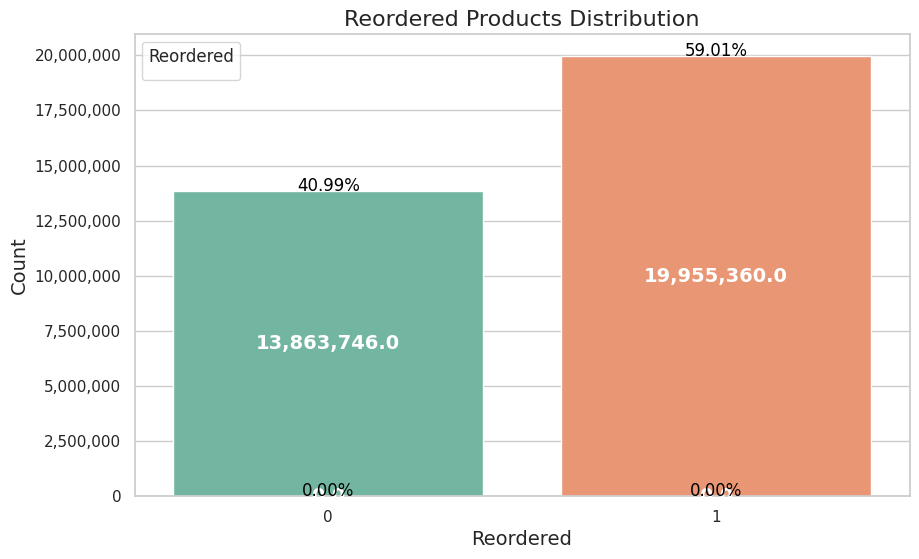

In [81]:
# 데이터프레임 병합 및 열 선택
order_products = pd.concat([order_products_prior, order_products_train])[['product_id', 'reordered']]

# 그래프 스타일 설정
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Seaborn을 사용한 막대 그래프 그리기
sns.countplot(data=order_products, dodge=False, x="reordered", hue="reordered", palette="Set2")

# 각 막대에 텍스트 레이블 추가
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x() + p.get_width() / 2, p.get_height() / 2),
                ha="center", va="center", fontsize=14, fontweight="bold", color="white")

# y 축 레이블 설정
plt.ylabel("Count", fontsize=14)

# x 축 레이블 설정
plt.xlabel("Reordered", fontsize=14)

# y 축의 레이블을 천 단위로 설정
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# 범례 제거
plt.legend([], title="Reordered")

# x 축에 퍼센트 레이블 추가
total_count = len(order_products)
for i, p in enumerate(ax.patches):
    percentage = (p.get_height() / total_count) * 100
    ax.annotate(f"{percentage:.2f}%", (p.get_x() + p.get_width() / 2, p.get_height() + 100),
                ha="center", fontsize=12, color="black")

# x 축 레이블 설정
plt.xlabel("Reordered", fontsize=14)

# 그래프 제목 설정
plt.title("Reordered Products Distribution", fontsize=16)

# 그래프 표시
plt.show()

장바구니 추가 순서 별 재구매율 현황

In [51]:
# order_products_prior와 order_products_train 데이터 합치기
temp_data = pd.concat([order_products_prior[['add_to_cart_order', 'reordered']], order_products_train[['add_to_cart_order', 'reordered']]], axis=0)
temp_data["add_to_cart_order_mod"] = temp_data["add_to_cart_order"]
temp_data["add_to_cart_order_mod"].loc[temp_data["add_to_cart_order_mod"] > 50] = 50

grouped_df = temp_data.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

grouped_df.head()

add_to_cart_order_mod  reordered
0                      1   0.679302
1                      2   0.677135
2                      3   0.658426
3                      4   0.637350
4                      5   0.617598

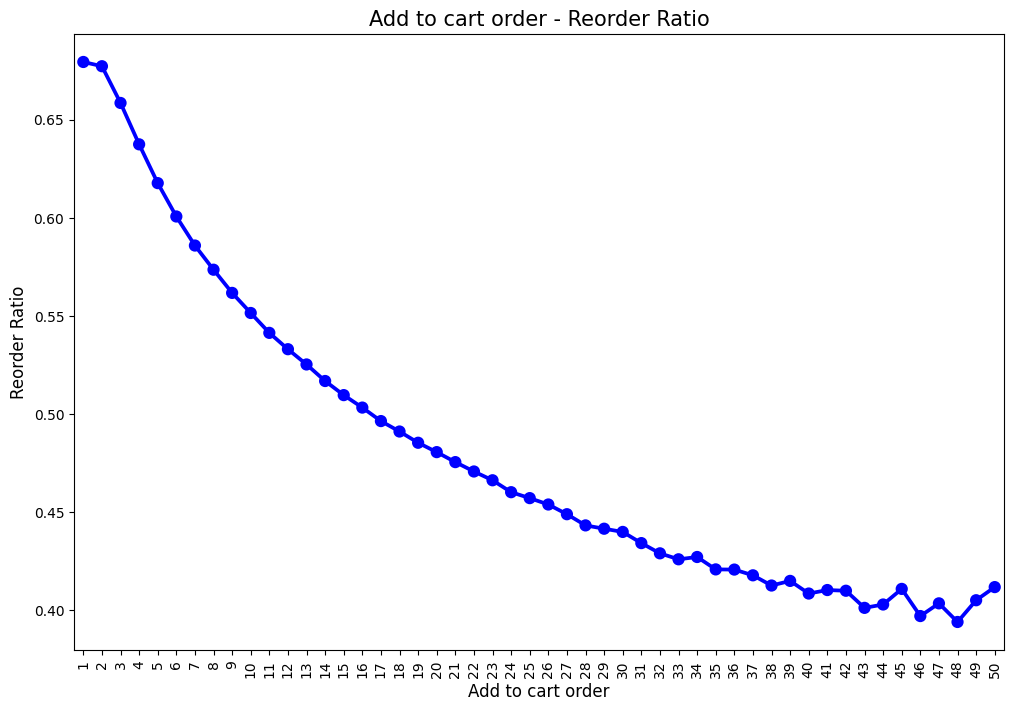

In [33]:
plt.figure(figsize=(12, 8))
sns.pointplot(x=grouped_df['add_to_cart_order_mod'].values, y=grouped_df['reordered'].values, color='b')

plt.xlabel('Add to cart order', fontsize=12)
plt.ylabel('Reorder Ratio', fontsize=12)
plt.title("Add to cart order - Reorder Ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

order_id 별 상품의 중복 aisle 비율

In [65]:
aisles_1 = pd.merge(selected_data, products[['product_id', 'aisle_id',]], on='product_id', how='left')
aisles_1 = pd.merge(aisles_1, aisles[['aisle_id', 'aisle',]], on='aisle_id', how='left')
aisles_1

order_id  product_id  aisle_id                          aisle
0                2       33120        86                           eggs
1                2       28985        83               fresh vegetables
2                2        9327       104              spices seasonings
3                2       45918        19                  oils vinegars
4                2       30035        17             baking ingredients
...            ...         ...       ...                            ...
33819101   3421063       14233       115  water seltzer sparkling water
33819102   3421063       35548        13                 prepared meals
33819103   3421070       35951        91                soy lactosefree
33819104   3421070       16953        88                        spreads
33819105   3421070        4724        32               packaged produce

[33819106 rows x 4 columns]

In [66]:
aisles_temp = aisles_1['aisle'].value_counts()
aisles_temp

aisle
fresh fruits                  3792661
fresh vegetables              3568630
packaged vegetables fruits    1843806
yogurt                        1507583
packaged cheese               1021462
                               ...   
eye ear care                     9522
baby bath body care              8909
baby accessories                 8466
beauty                           6455
frozen juice                     5147
Name: count, Length: 134, dtype: int64

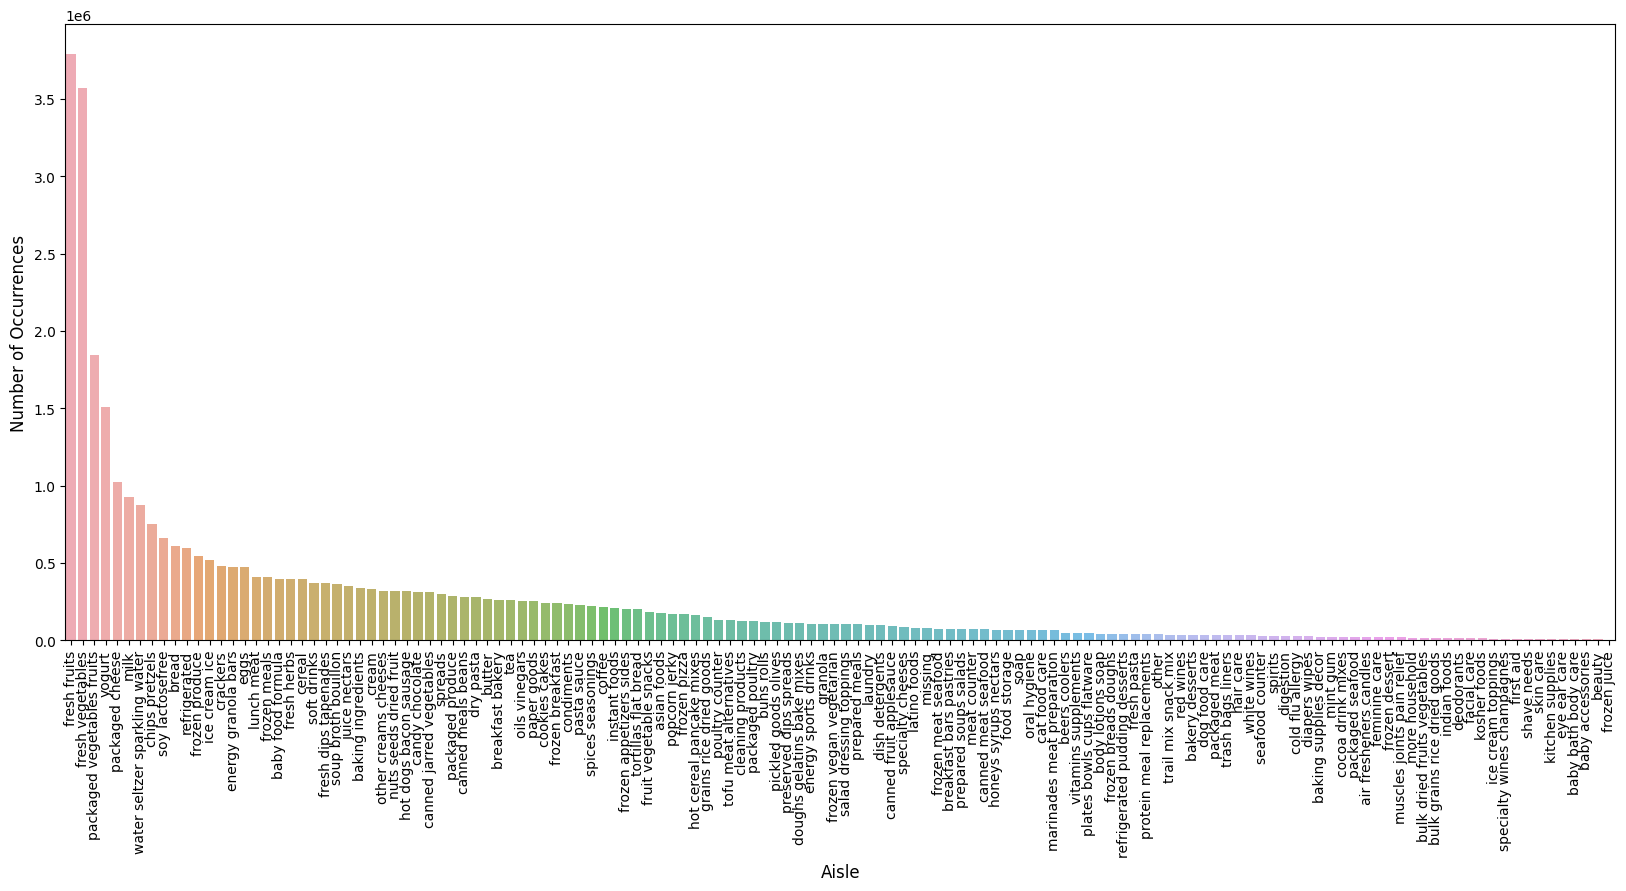

In [68]:
plt.figure(figsize=(20, 8))
sns.barplot(x=aisles_temp.index, y=aisles_temp.values, alpha=0.8)

plt.xlabel('Aisle', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [69]:
# 'order_id'를 기준으로 데이터를 그룹화하고, 'aisle'을 데이터별로 카운트
aisle_counts_by_order = aisles_1.groupby(['order_id', 'aisle']).size().reset_index(name='count')

# 결과 확인
print(aisle_counts_by_order.head(20))

    order_id                       aisle  count
0          1         canned meat seafood      1
1          1                fresh fruits      2
2          1            fresh vegetables      2
3          1        other creams cheeses      1
4          1             packaged cheese      1
5          1                      yogurt      1
6          2          baking ingredients      1
7          2  doughs gelatins bake mixes      1
8          2                        eggs      1
9          2            fresh vegetables      2
10         2               oils vinegars      1
11         2  packaged vegetables fruits      1
12         2           spices seasonings      1
13         2                     spreads      1
14         3                       bread      1
15         3            fresh vegetables      1
16         3  packaged vegetables fruits      2
17         3             poultry counter      1
18         3             soy lactosefree      2
19         3                      yogurt

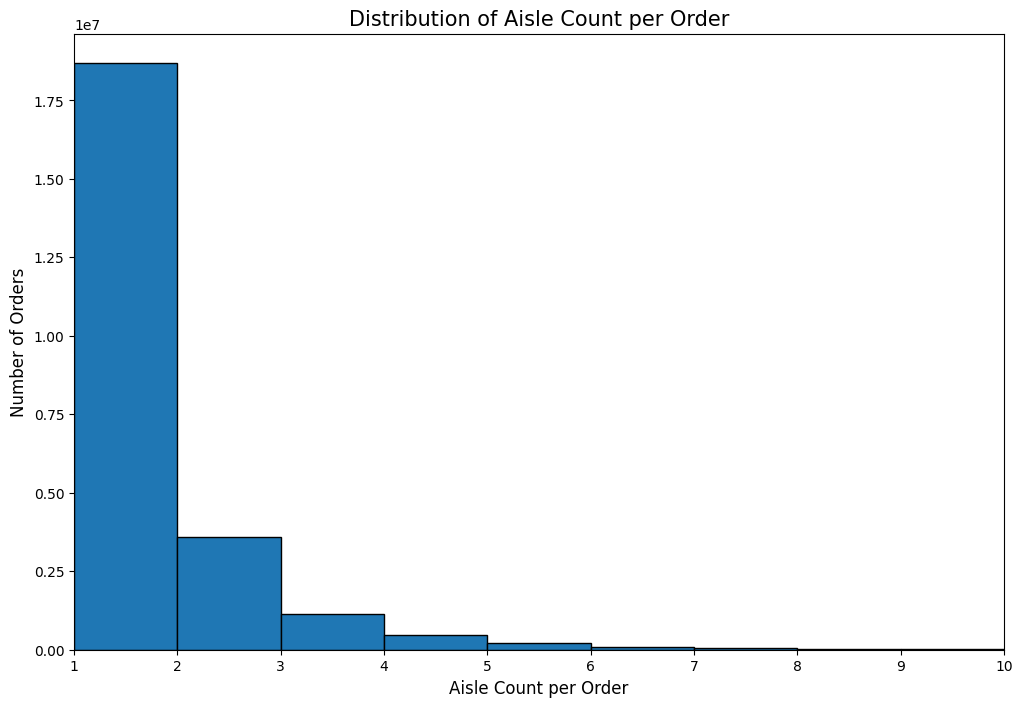

In [70]:
# 주문별 'aisle'의 발생 빈도를 히스토그램으로 그립니다.
plt.figure(figsize=(12, 8))
plt.hist(aisle_counts_by_order['count'], bins=range(1, 11), edgecolor='k', align='mid')
plt.xlabel('Aisle Count per Order', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Distribution of Aisle Count per Order', fontsize=15)

# x축 범위를 1에서 10까지 설정하고, 눈금을 1부터 10까지 설정
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.show()

In [71]:
# aisle_counts_by_order에서 count가 2 이상인 행만 필터링
filtered_data = aisle_counts_by_order[aisle_counts_by_order['count'] >= 2]

# order_id 별로 (count가 2 이상인 숫자의 합계)를 계산
sum_counts = filtered_data.groupby('order_id')['count'].sum().reset_index()

# order_id 별로 전체 count 수를 계산
total_counts = aisle_counts_by_order.groupby('order_id')['count'].sum().reset_index()

# (count가 2 이상인 숫자의 합계) / (order_id의 count 전체 수) 계산
result = pd.merge(sum_counts, total_counts, on='order_id', suffixes=('_sum', '_total'))
result['ratio'] = result['count_sum'] / result['count_total']

result

order_id  count_sum  count_total     ratio
0               1          4            8  0.500000
1               2          2            9  0.222222
2               3          4            8  0.500000
3               4          6           13  0.461538
4               5         11           26  0.423077
...           ...        ...          ...       ...
2390874   3421075          5            8  0.625000
2390875   3421077          2            4  0.500000
2390876   3421078          5            9  0.555556
2390877   3421080          3            9  0.333333
2390878   3421083          4           10  0.400000

[2390879 rows x 4 columns]

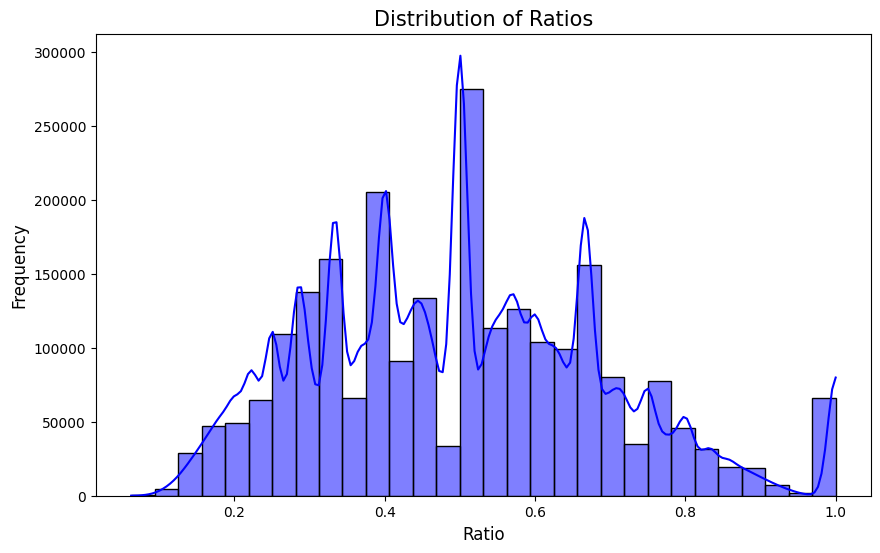

In [72]:
# 비율 데이터를 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
sns.histplot(result['ratio'], bins=30, kde=True, color='blue')
plt.xlabel('Ratio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Ratios', fontsize=15)
plt.show()

이용자 재구매 주기 현황

Most frequently next orders are made once in: 30 days
We clearly see monthly (>=30) and weekly (7) peaks


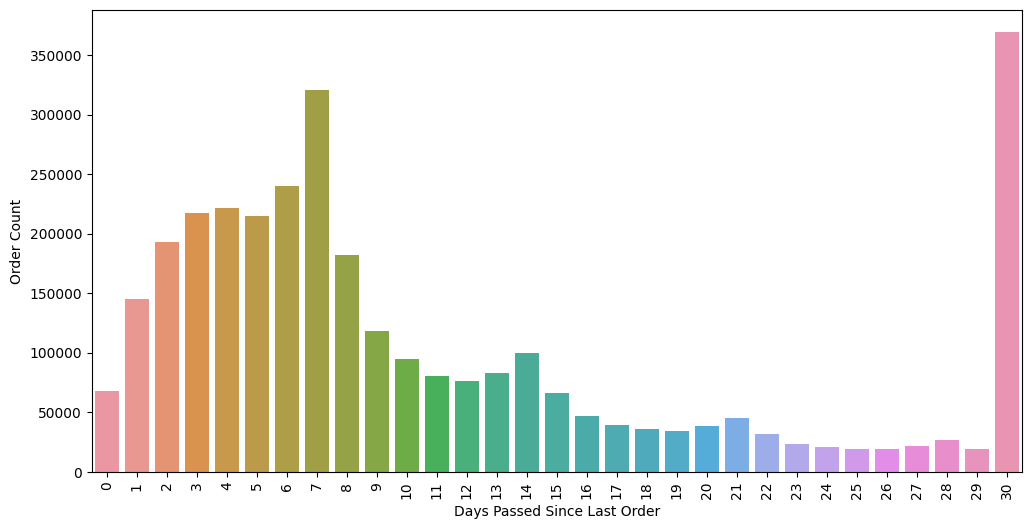

In [74]:
# 데이터프레임에서 결측치를 제거하고 평균을 계산하여 새로운 데이터프레임을 생성
order_details = orders.dropna(axis=0, subset=['days_since_prior_order'])
mean_days_since_prior_order = order_details.groupby('order_id')['days_since_prior_order'].agg("mean").reset_index().apply(np.int32)

# 'days_since_prior_order' 값을 기준으로 주문 수를 집계
order_counts_by_days = mean_days_since_prior_order.groupby('days_since_prior_order').agg("count")

# 가장 빈번하게 다음 주문이 발생하는 일수를 찾아 출력
most_frequent_next_order_days = order_counts_by_days[order_counts_by_days['order_id'] == order_counts_by_days['order_id'].max()].index[0]
print('Most frequently next orders are made once in: {} days'.format(most_frequent_next_order_days))
print('We clearly see monthly (>=30) and weekly (7) peaks')

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=order_counts_by_days.index, y=order_counts_by_days['order_id'])
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Days Passed Since Last Order')
plt.show()

재구매 비율이 높은 상품군


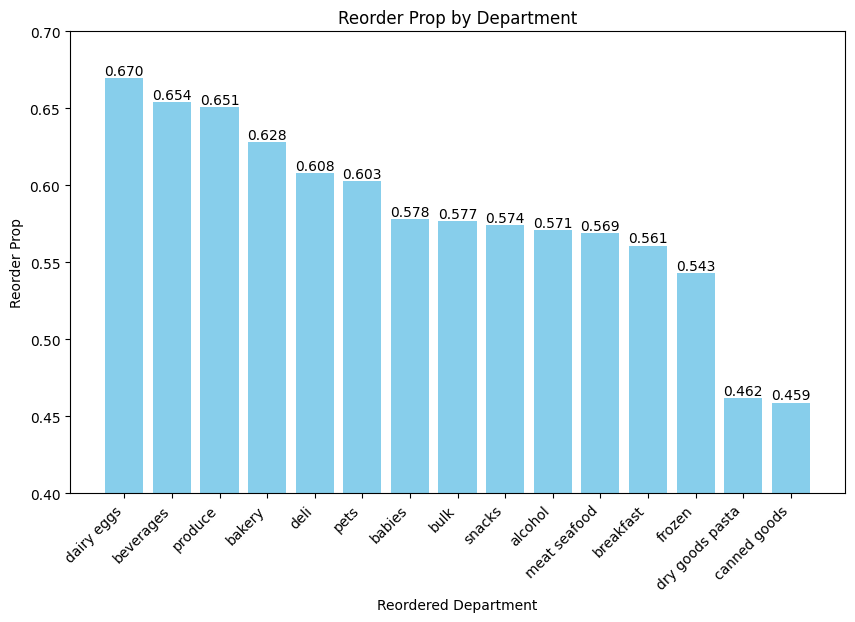

In [75]:
# 데이터프레임 병합 및 열 선택
order_products = pd.concat([order_products_prior, order_products_train])[['product_id', 'reordered']]

# Step 1: order_products와 products를 조인하고 필요한 열 선택
tmp = pd.merge(order_products, products, left_on='product_id', right_on='product_id')
tmp = tmp[['department_id', 'reordered']]

# Step 2: department_id와 reordered를 기준으로 그룹화하여 reorderedFreq 계산
tmp = tmp.groupby(['department_id', 'reordered']).size().reset_index(name='reorderedFreq')

# Step 3: department_id를 기준으로 reorderedProp 계산
tmp['reorderedProp'] = tmp.groupby('department_id')['reorderedFreq'].transform(lambda x: round(x / x.sum(), 3))

# Step 4: department_id를 기준으로 Freq 계산
tmp['Freq'] = tmp.groupby('department_id')['reorderedFreq'].transform('sum')

# Step 5: reordered가 1인 경우 필터링하고 정렬
tmp_1 = tmp[tmp['reordered'] == 1]
tmp_1 = tmp_1.sort_values(by='reorderedProp', ascending=False)

# Step 6: departments 데이터와 조인하고 필요한 열 선택
tmp_1 = pd.merge(tmp_1, departments, left_on='department_id', right_on='department_id')
tmp_1 = tmp_1[['department', 'reorderedFreq', 'reorderedProp', 'Freq']].head(15)

# 그래프 그리기 
plt.figure(figsize=(10, 6))
plt.bar(tmp_1["department"], tmp_1["reorderedProp"], color="SkyBlue")
plt.xlabel("Reordered Department")
plt.ylabel("Reorder Prop")
plt.title("Reorder Prop by Department")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.4, 0.7)  # y 축 범위 설정

# 텍스트 레이블 추가
for x, y in zip(tmp_1["department"], tmp_1["reorderedProp"]):
    plt.text(x, y, f"{y:.3f}", ha="center", va="bottom", fontsize=10)
plt.show()

# 메모리 해제
del order_products, tmp, tmp_1

재구매 비율이 높은 상품


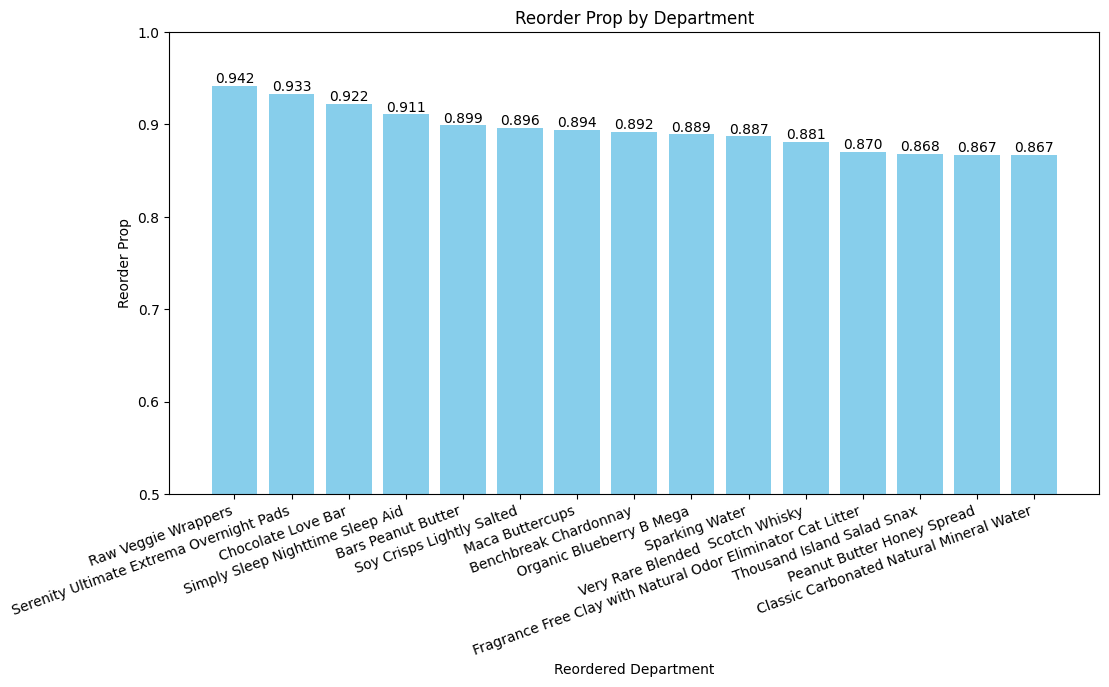

In [76]:
# 데이터프레임 병합 및 열 선택
order_products = pd.concat([order_products_prior, order_products_train])[['product_id', 'reordered']]

# 데이터프레임 병합
merged_data = pd.merge(order_products, products, on="product_id", how="left")

# 그룹화 및 요약 통계 계산
tmp = merged_data.groupby(["product_id", "reordered"]).size().reset_index(name="reorderedFreq")
tmp["reorderedProp"] = tmp.groupby("product_id")["reorderedFreq"].transform(lambda x: round(x / x.sum(), 3))
tmp["Freq"] = tmp.groupby("product_id")["reorderedFreq"].transform("sum")

# 필터링 및 정렬
tmp_1 = tmp[(tmp["reordered"] == 1) & (tmp["Freq"] > 40)].sort_values(by="reorderedProp", ascending=False).head(15)

# 필요한 열 선택
tmp_1 = tmp_1[["product_id", "reorderedFreq", "reorderedProp", "Freq"]]

# 상품명 추가
tmp_1 = pd.merge(tmp_1, products, on="product_id", how="left")

# 그래프 그리기 
plt.figure(figsize=(12, 6))
plt.bar(tmp_1["product_name"], tmp_1["reorderedProp"], color="SkyBlue")
plt.xlabel("Reordered Department")
plt.ylabel("Reorder Prop")
plt.title("Reorder Prop by Department")
plt.xticks(rotation=20, ha="right")
plt.ylim(0.5, 1.0)  # y 축 범위 설정

# 텍스트 레이블 추가
for x, y in zip(tmp_1["product_name"], tmp_1["reorderedProp"]):
    plt.text(x, y, f"{y:.3f}", ha="center", va="bottom", fontsize=10)

plt.show()

# 메모리 해제
del order_products, merged_data, tmp, tmp_1

일반/유기농 상품의 재구매율


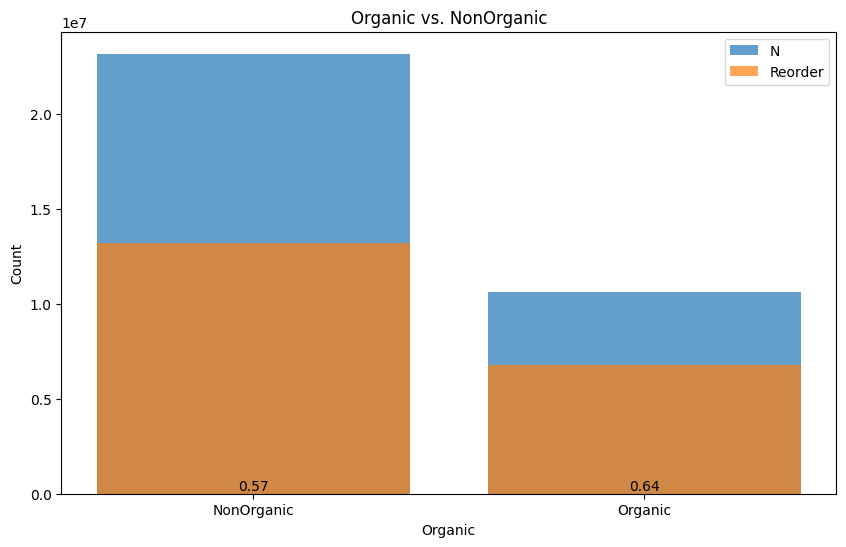

In [77]:
# 데이터프레임 병합 및 열 선택
order_products = pd.concat([order_products_prior, order_products_train])[['product_id', 'reordered']]
product_tmp = products[['product_id', 'product_name']]

merged_data = pd.merge(order_products, product_tmp, on="product_id", how="left")
selected_data = merged_data[["product_name", "reordered"]]

# "Organic" 및 "NonOrganic" 열 생성
selected_data["Organic"] = selected_data["product_name"].str.contains("Organic | organic", case=False, regex=True).fillna(False)
selected_data["Organic"] = selected_data["Organic"].apply(lambda x: "Organic" if x else "NonOrganic")

# 그룹화 및 요약 통계 계산
grouped_data = selected_data.groupby("Organic").agg(
    N=("Organic", "size"),
    Reorder=("reordered", "sum"),
    ReorderProp=("reordered", "mean")
).reset_index()

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(grouped_data["Organic"], grouped_data["N"], label="N", alpha=0.7)
plt.bar(grouped_data["Organic"], grouped_data["Reorder"], label="Reorder", alpha=0.7)
plt.xlabel("Organic")
plt.ylabel("Count")
plt.legend()
plt.title("Organic vs. NonOrganic")

# ReorderProp을 표시
for index, row in grouped_data.iterrows():
    plt.text(row.name, row["ReorderProp"], round(row["ReorderProp"], 2), ha="center", va="bottom")

plt.show()

# 메모리 해제
del grouped_data, product_tmp, merged_data, selected_data, order_products

일반/유기농 제품 재구매 주기


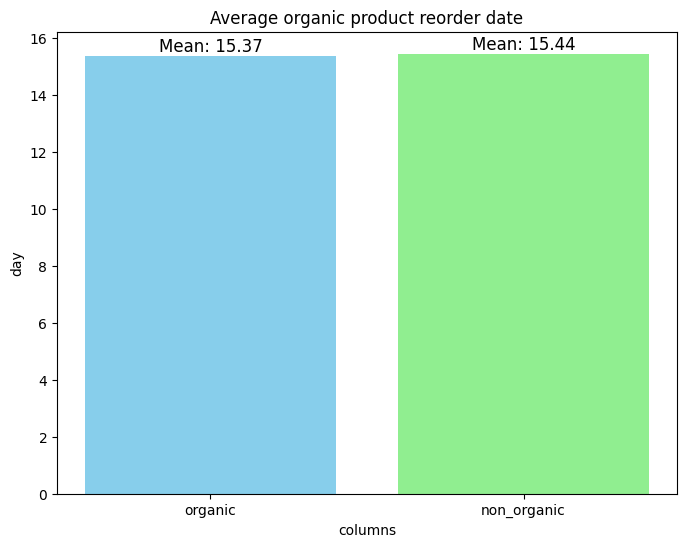

In [78]:
# 'Organic'이 포함된 제품 필터링
organic_products = products[products['product_name'].str.contains('Organic')]

# 해당 제품들의 ID를 사용하여 order_products_prior와 order_products_train에서 해당 주문 필터링
organic_orders_prior = order_products_prior[order_products_prior['product_id'].isin(organic_products['product_id'])]
organic_orders_train = order_products_train[order_products_train['product_id'].isin(organic_products['product_id'])]

# 두 데이터를 결합
organic_orders = pd.concat([organic_orders_prior, organic_orders_train])

# 필터링된 주문을 orders 데이터와 결합
organic_order_details = pd.merge(organic_orders, orders, on='order_id', how='left')

# 각 user_id별로 days_since_prior_order의 평균 계산
average_purchase_cycle = organic_order_details.groupby('user_id')['days_since_prior_order'].mean().reset_index()

# 'Organic'이 포함되지 않은 제품 필터링
non_organic_products = products[~products['product_name'].str.contains('Organic')]

# 해당 제품들의 ID를 사용하여 order_products_prior와 order_products_train에서 해당 주문 필터링
non_organic_orders_prior = order_products_prior[order_products_prior['product_id'].isin(non_organic_products['product_id'])]
non_organic_orders_train = order_products_train[order_products_train['product_id'].isin(non_organic_products['product_id'])]

# 두 데이터를 결합
non_organic_orders = pd.concat([non_organic_orders_prior, non_organic_orders_train])

# 필터링된 주문을 orders 데이터와 결합
non_organic_order_details = pd.merge(non_organic_orders, orders, on='order_id', how='left')

# 각 user_id별로 days_since_prior_order의 평균 계산
average_non_organic_purchase_cycle = non_organic_order_details.groupby('user_id')['days_since_prior_order'].mean().reset_index()

# 각 user_id별로 유기농상품, 일반상품 Merge
merged_purchase_cycles = pd.merge(average_purchase_cycle, average_non_organic_purchase_cycle, on='user_id', suffixes=('_organic', '_non_organic'))

# 유기농상품과 일반상품 재주문 평균일 계산
days_since_prior_order_organic_min = merged_purchase_cycles['days_since_prior_order_organic'].mean()
days_since_prior_order_non_organic_min = merged_purchase_cycles['days_since_prior_order_non_organic'].mean()

# 시각화
plt.figure(figsize=(8, 6))
plt.bar(['organic', 'non_organic'], [days_since_prior_order_organic_min, days_since_prior_order_non_organic_min], color=['skyblue', 'lightgreen'])
plt.title('Average organic product reorder date')
plt.xlabel('columns')
plt.ylabel('day')
plt.xticks(rotation=0)
plt.text(0, days_since_prior_order_organic_min, f'Mean: {days_since_prior_order_organic_min:.2f}', ha='center', va='bottom', fontsize=12)
plt.text(1, days_since_prior_order_non_organic_min, f'Mean: {days_since_prior_order_non_organic_min:.2f}', ha='center', va='bottom', fontsize=12)
plt.show()

# 메모리 해제
del organic_products, organic_orders_prior, organic_orders_train, non_organic_orders_prior, non_organic_orders_train, organic_orders, \
average_purchase_cycle, non_organic_order_details, average_non_organic_purchase_cycle, merged_purchase_cycles, days_since_prior_order_organic_min, days_since_prior_order_non_organic_min

상품별 재구매 주기


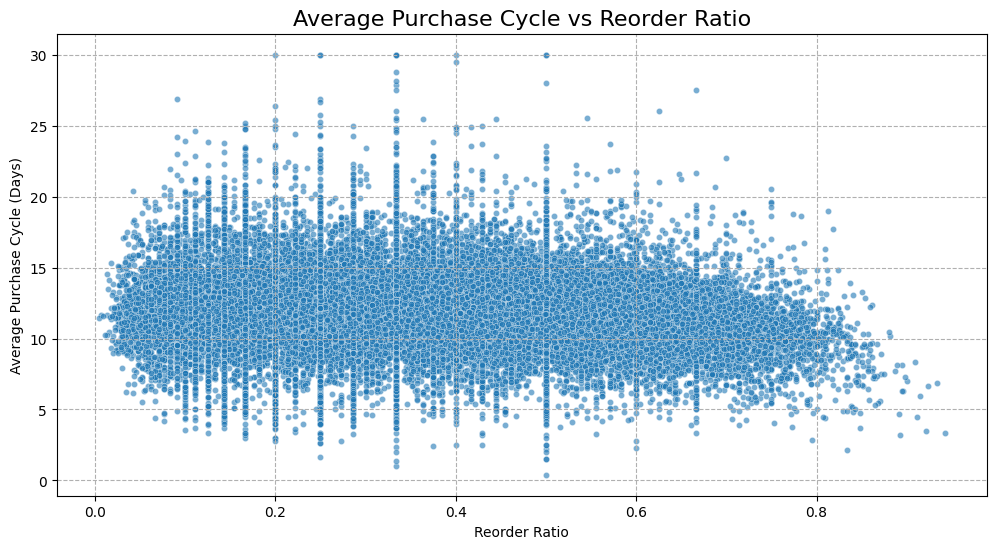

In [79]:
# 필요한 컬럼만 추출
subset_data = pd.concat([order_products_prior, order_products_train])[['order_id', 'product_id', 'reordered']]
subset_data = subset_data.merge(orders[['order_id', 'days_since_prior_order']], on='order_id', how='left')

# 1. 재구매율 계산
reorder_counts = subset_data.groupby('product_id')['reordered'].sum()
total_counts = subset_data['product_id'].value_counts()
reorder_ratio = (reorder_counts / total_counts).reset_index()
reorder_ratio.columns = ['product_id', 'reorder_ratio']

# 2. 구매 주기 계산
purchase_cycle = subset_data.groupby('product_id')['days_since_prior_order'].mean().reset_index()
purchase_cycle.columns = ['product_id', 'average_purchase_cycle']

# 데이터 합치기
product_stats = reorder_ratio.merge(purchase_cycle, on='product_id', how='left')

# 재구매율 0% 데이터 제거
product_stats = product_stats[product_stats['reorder_ratio'] != 0]

# 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(data=product_stats, x="reorder_ratio", y="average_purchase_cycle", alpha=0.6, edgecolor='w', s=20)

plt.title("Average Purchase Cycle vs Reorder Ratio", fontsize=16)
plt.xlabel("Reorder Ratio")
plt.ylabel("Average Purchase Cycle (Days)")
plt.grid(True, linestyle='--')
plt.show()

# 메모리 해제
del purchase_cycle, product_stats, subset_data, reorder_counts, reorder_ratio

EDA 한 결과를 바탕으로 머신러닝 돌려 예상구매 제품 구해보기

In [105]:
orders['eval_set'] = orders['eval_set'].astype('category')
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype('int')

products['product_name'] = products['product_name'].astype('category')

aisles['aisle'] = aisles['aisle'].astype('category')

departments['department'] = departments['department'].astype('category')

In [106]:
order_products_prior = pd.merge(order_products_prior, orders, on="order_id", how="left")

# select 연산
order_products_prior = order_products_prior[[
    "user_id", "order_id", "order_number", "order_hour_of_day", 
    "days_since_prior_order", "product_id", "add_to_cart_order", "reordered"
]]

# arrange 연산
order_products_prior = order_products_prior.sort_values(by=["user_id", "order_number", "add_to_cart_order"])

In [107]:
order_products_prior

user_id  order_id  order_number  order_hour_of_day  \
24076664        1   2539329             1                  8   
24076665        1   2539329             1                  8   
24076666        1   2539329             1                  8   
24076667        1   2539329             1                  8   
24076668        1   2539329             1                  8   
...           ...       ...           ...                ...   
28236065   206209   2977660            13                 12   
28236066   206209   2977660            13                 12   
28236067   206209   2977660            13                 12   
28236068   206209   2977660            13                 12   
28236069   206209   2977660            13                 12   

          days_since_prior_order  product_id  add_to_cart_order  reordered  
24076664                     NaN         196                  1          0  
24076665                     NaN       14084                  2          0  
24076666                     NaN       12427                  3          0  
24076667                     NaN       26088                  4          0  
24076668                     NaN       26405                  5          0  
...                          ...         ...                ...        ...  
28236065                     7.0       14197                  5          1  
28236066                     7.0       38730                  6          0  
28236067                     7.0       31477                  7          0  
28236068                     7.0        6567                  8          0  
28236069                     7.0       22920                  9          0  

[32434489 rows x 8 columns]

In [108]:
order_products_train = pd.merge(order_products_train, orders, on="order_id", how="left")

# select 연산
order_products_train = order_products_train[["user_id", "product_id", "reordered"]]

# arrange 연산
order_products_train = order_products_train.sort_values(by=["user_id", "product_id"])

In [109]:
order_products_train

user_id  product_id  reordered
484420        1         196          1
484425        1       10258          1
484426        1       13032          1
484421        1       25133          1
484427        1       26088          1
...         ...         ...        ...
111266   206209       24852          1
111270   206209       37966          0
111271   206209       39216          1
111267   206209       40603          0
111269   206209       42606          0

[1384617 rows x 3 columns]

In [110]:
order_products_prior['product_time'] = order_products_prior.groupby(['user_id', 'product_id']).cumcount() + 1

products_stat = order_products_prior

In [111]:
products_stat

user_id  order_id  order_number  order_hour_of_day  \
24076664        1   2539329             1                  8   
24076665        1   2539329             1                  8   
24076666        1   2539329             1                  8   
24076667        1   2539329             1                  8   
24076668        1   2539329             1                  8   
...           ...       ...           ...                ...   
28236065   206209   2977660            13                 12   
28236066   206209   2977660            13                 12   
28236067   206209   2977660            13                 12   
28236068   206209   2977660            13                 12   
28236069   206209   2977660            13                 12   

          days_since_prior_order  product_id  add_to_cart_order  reordered  \
24076664                     NaN         196                  1          0   
24076665                     NaN       14084                  2          0   
24076666                     NaN       12427                  3          0   
24076667                     NaN       26088                  4          0   
24076668                     NaN       26405                  5          0   
...                          ...         ...                ...        ...   
28236065                     7.0       14197                  5          1   
28236066                     7.0       38730                  6          0   
28236067                     7.0       31477                  7          0   
28236068                     7.0        6567                  8          0   
28236069                     7.0       22920                  9          0   

          product_time  
24076664             1  
24076665             1  
24076666             1  
24076667             1  
24076668             1  
...                ...  
28236065             2  
28236066             1  
28236067             1  
28236068             1  
28236069             1  

[32434489 rows x 9 columns]

In [112]:
grouped = products_stat.groupby('product_id')

# summarise 연산
products_stat = grouped.agg(
    prod_N=pd.NamedAgg(column='product_id', aggfunc='size'),           #해당 상품의 전체 판매 빈도
    prod_ReorderedRatio=pd.NamedAgg(column='reordered', aggfunc='mean'),     #해당 상품의 전체 판매 중 재구매에 의한 판매 비율
    prod_FirstOrders=pd.NamedAgg(column='product_time', aggfunc=lambda x: (x == 1).sum()),  #해당 상품을 처음 구매한 고객의 수
    prod_SecondOrders=pd.NamedAgg(column='product_time', aggfunc=lambda x: (x == 2).sum()),
    prod_OrderedTime=pd.NamedAgg(column='order_hour_of_day', aggfunc='median'),      #해당 상품이 주로 주문되는 시간
    prod_ReorderedPeriod=pd.NamedAgg(column='days_since_prior_order', aggfunc='median'),  #해당 상품의 재주문 기간
    prod_CartOrder=pd.NamedAgg(column='add_to_cart_order', aggfunc='median') #해당 상품이 주로 장바구니에 담기는 순서
).reset_index()

products_stat['prod_ReorderedProb'] = products_stat['prod_SecondOrders'] / products_stat['prod_FirstOrders'] #해당 상품을 재구매할 확률

# select 연산
products_stat = products_stat.drop(columns=['prod_FirstOrders', 'prod_SecondOrders'])

In [113]:
products_stat.head()

product_id  prod_N  prod_ReorderedRatio  prod_OrderedTime  \
0           1    1852             0.613391              13.0   
1           2      90             0.133333              13.0   
2           3     277             0.732852              12.0   
3           4     329             0.446809              14.0   
4           5      15             0.600000              11.0   

   prod_ReorderedPeriod  prod_CartOrder  prod_ReorderedProb  
0                   7.0             4.0            0.385475  
1                   7.0             8.0            0.102564  
2                   7.0             4.0            0.486486  
3                  12.0             8.0            0.351648  
4                   7.5             6.0            0.666667

In [114]:
# filter 연산
filtered_orders = orders[orders['eval_set'] == "prior"]

# group_by와 summarise 연산
grouped = filtered_orders.groupby('user_id')

tmp1 = grouped.agg(
    user_OrderN=pd.NamedAgg(column='order_number', aggfunc='max'),
    user_Period=pd.NamedAgg(column='days_since_prior_order', aggfunc='sum'),
    user_ReorderedPeriod=pd.NamedAgg(column='days_since_prior_order', aggfunc='median')
).reset_index()

In [115]:
grouped = order_products_prior.groupby('user_id')
tmp2 = grouped.agg(
    user_ProductN=pd.NamedAgg(column='product_id', aggfunc='size'),
    user_ReorderedRatio=pd.NamedAgg(column='reordered', aggfunc=lambda x: x.sum() / (len(x[x > 1]) or 1)),
    user_ProductDistinct=pd.NamedAgg(column='product_id', aggfunc='nunique')
).reset_index()

In [116]:
# left_join 연산 및 mutate 연산
users_stat = pd.merge(tmp1, tmp2, on='user_id', how='left')
users_stat['user_CartAverage'] = users_stat['user_ProductN'] / users_stat['user_OrderN']

del tmp1, tmp2

# filter 및 select 연산
tmp3 = orders[orders['eval_set'] != "prior"]
tmp3 = tmp3[['user_id', 'order_id', 'eval_set', 'order_hour_of_day', 'days_since_prior_order']]

# left_join 연산
users_stat = pd.merge(users_stat, tmp3, on='user_id', how='left')

del tmp3

In [117]:
users_stat

user_id  user_OrderN  user_Period  user_ReorderedPeriod  \
0             1           10        176.0                  20.0   
1             2           14        198.0                  13.0   
2             3           12        133.0                  11.0   
3             4            5         55.0                  17.0   
4             5            4         40.0                  11.0   
...         ...          ...          ...                   ...   
206204   206205            3         40.0                  20.0   
206205   206206           67        249.0                   3.0   
206206   206207           16        215.0                   8.0   
206207   206208           49        357.0                   7.0   
206208   206209           13        210.0                  20.0   

        user_ProductN  user_ReorderedRatio  user_ProductDistinct  \
0                  59                 41.0                    18   
1                 195                 93.0                   102   
2                  88                 55.0                    33   
3                  18                  1.0                    17   
4                  37                 14.0                    23   
...               ...                  ...                   ...   
206204             32                  8.0                    24   
206205            285                135.0                   150   
206206            223                131.0                    92   
206207            677                479.0                   198   
206208            129                 61.0                    68   

        user_CartAverage  order_id eval_set  order_hour_of_day  \
0               5.900000   1187899    train                  8   
1              13.928571   1492625    train                 11   
2               7.333333   2774568     test                 15   
3               3.600000    329954     test                 12   
4               9.250000   2196797    train                 11   
...                  ...       ...      ...                ...   
206204         10.666667   1716008    train                 16   
206205          4.253731   1043943     test                 20   
206206         13.937500   2821651     test                 13   
206207         13.816327    803273     test                 11   
206208          9.923077    272231    train                 14   

        days_since_prior_order  
0                         14.0  
1                         30.0  
2                         11.0  
3                         30.0  
4                          6.0  
...                        ...  
206204                    10.0  
206205                     0.0  
206206                    14.0  
206207                     4.0  
206208                    30.0  

[206209 rows x 12 columns]

In [118]:
purchase_list = order_products_prior[(order_products_prior['order_number'] <= 10) & (order_products_prior['add_to_cart_order'] <= 10)]

# group_by와 summarise 연산
grouped = purchase_list.groupby(['user_id', 'product_id'])

purchase_list = grouped.agg(
    pl_N=pd.NamedAgg(column='product_id', aggfunc='size'),
    pl_FirstPurchase=pd.NamedAgg(column='order_number', aggfunc='min'),
    pl_LastPurchase=pd.NamedAgg(column='order_number', aggfunc='max'),
    pl_CartOrder=pd.NamedAgg(column='add_to_cart_order', aggfunc='median')
).reset_index()

In [119]:
purchase_list = pd.merge(purchase_list, products_stat, on='product_id', how='inner')

# 두 번째 inner_join 연산
purchase_list = pd.merge(purchase_list, users_stat, on='user_id', how='inner')

In [120]:
purchase_list['pl_OrderRate'] = purchase_list['pl_N'] / purchase_list['user_OrderN']

    # 해당 고객의 해당 상품 주문율 = 해당 고객이 해당 상품을 구매한 횟수 / 고객별 총 주문 횟수
    # pl_OrderSinceLastOrder = user_OrderN - pl_LastPurchase, 
    #  해당 고객이 해당 상품을 마지막으로 구매한 이후 현재까지의 기간
    #  = 고객별 총 주문 횟수 - 해당 고객이 해당 상품을 언제 마지막으로 주문했는가.
    #  값이 작을수록 '해당 고객이 해당 상품을 최근에 구매했다.'란 의미.
    #  (성능의 한계로 인해, 최대 주문 횟수를 제한했기 때문에 해당 변수를 생성하지는 않겠습니다.)

purchase_list['pl_OrderRateSinceFirstOrder'] = purchase_list['pl_N'] / (purchase_list['user_OrderN'] - purchase_list['pl_FirstPurchase'] + 1)
    #  해당 고객이 해당 상품을 처음 접한 이후 얼마나 자주 구매하는가.
    #  =  해당 고객이 해당 상품을 구매한 횟수 /
    #       (고객별 총 주문 횟수 - 해당 고객이 해당 상품을 언제 처음 주문했는가.)
    #  값이 클수록 '해당 고객이 해당 상품을 처음 접한 이후 많이 구매했다.'란 의미.

In [121]:
purchase_list

user_id  product_id  pl_N  pl_FirstPurchase  pl_LastPurchase  \
0              1         196    10                 1               10   
1              1       10258     9                 2               10   
2              1       10326     1                 5                5   
3              1       12427    10                 1               10   
4              1       13032     3                 2               10   
...          ...         ...   ...               ...              ...   
6686559   178074       19318    10                 1               10   
6686560   105857       23767     6                 1                6   
6686561   166751       49001     3                 1                3   
6686562   106143       19675    10                 1               10   
6686563    66343       47210     4                 1                4   

         pl_CartOrder  prod_N  prod_ReorderedRatio  prod_OrderedTime  \
0                 1.0   35791             0.776480              12.0   
1                 3.0    1946             0.713772              12.0   
2                 5.0    5526             0.652009              12.0   
3                 2.5    6476             0.740735              12.0   
4                 6.0    3751             0.657158              12.0   
...               ...     ...                  ...               ...   
6686559           1.0     175             0.777143              14.0   
6686560           1.0     224             0.517857              14.0   
6686561           1.0      45             0.311111              14.0   
6686562           1.0      39             0.846154              14.0   
6686563           1.0      11             0.363636              12.0   

         prod_ReorderedPeriod  ...  user_ProductN  user_ReorderedRatio  \
0                         8.0  ...             59                 41.0   
1                         8.0  ...             59                 41.0   
2                         8.0  ...             59                 41.0   
3                         7.0  ...             59                 41.0   
4                         8.0  ...             59                 41.0   
...                       ...  ...            ...                  ...   
6686559                   4.0  ...             12                 11.0   
6686560                   9.0  ...              6                  5.0   
6686561                   7.0  ...              3                  2.0   
6686562                   6.5  ...             26                 25.0   
6686563                  19.5  ...              4                  3.0   

         user_ProductDistinct  user_CartAverage  order_id  eval_set  \
0                          18               5.9   1187899     train   
1                          18               5.9   1187899     train   
2                          18               5.9   1187899     train   
3                          18               5.9   1187899     train   
4                          18               5.9   1187899     train   
...                       ...               ...       ...       ...   
6686559                     1               1.0   2250575     train   
6686560                     1               1.0    544191      test   
6686561                     1               1.0   2080697     train   
6686562                     1               1.0   1714200      test   
6686563                     1               1.0   2913671      test   

         order_hour_of_day  days_since_prior_order  pl_OrderRate  \
0                        8                    14.0      1.000000   
1                        8                    14.0      0.900000   
2                        8                    14.0      0.100000   
3                        8                    14.0      1.000000   
4                        8                    14.0      0.300000   
...                    ...                     ...           ...   
6686559                 11                     7.

In [122]:
# left_join 연산
purchase_list = pd.merge(purchase_list, order_products_train, on=['user_id', 'product_id'], how='left')

# 데이터프레임 제거
del order_products_prior, order_products_train, products_stat, users_stat, orders

# display (knitr::kable와 유사한) 결과를 표시
purchase_list.head(20)

user_id  product_id  pl_N  pl_FirstPurchase  pl_LastPurchase  \
0         1         196    10                 1               10   
1         1       10258     9                 2               10   
2         1       10326     1                 5                5   
3         1       12427    10                 1               10   
4         1       13032     3                 2               10   
5         1       13176     2                 2                5   
6         1       14084     1                 1                1   
7         1       17122     1                 5                5   
8         1       25133     8                 3               10   
9         1       26088     2                 1                2   
10        1       26405     2                 1                4   
11        1       30450     1                 3                3   
12        1       35951     1                10               10   
13        1       38928     1                10               10   
14        1       39657     1                10               10   
15        1       41787     1                 5                5   
16        1       46149     3                 8               10   
17        1       49235     2                 8                9   
18       19         196     2                 2                7   
19       19       17224     1                 6                6   

    pl_CartOrder  prod_N  prod_ReorderedRatio  prod_OrderedTime  \
0            1.0   35791             0.776480              12.0   
1            3.0    1946             0.713772              12.0   
2            5.0    5526             0.652009              12.0   
3            2.5    6476             0.740735              12.0   
4            6.0    3751             0.657158              12.0   
5            6.0  379450             0.832555              13.0   
6            2.0   15935             0.810982              13.0   
7            6.0   13880             0.675576              12.0   
8            4.0    6196             0.740155              13.0   
9            4.5    2523             0.539041              13.0   
10           5.0    1214             0.441516              12.0   
11           5.0   21490             0.566682              13.0   
12           7.0   57895             0.757837              13.0   
13           4.0   13238             0.827769              12.0   
14           3.0    5019             0.766288              12.0   
15           7.0   35413             0.649903              13.0   
16           2.0    8558             0.812456              12.0   
17           3.5   76360             0.781456              12.0   
18           2.0   35791             0.776480              12.0   
19           5.0    7987             0.620258              12.0   

    prod_ReorderedPeriod  ...  user_ReorderedRatio  user_ProductDistinct  \
0                    8.0  ...                 41.0                    18   
1                    8.0  ...                 41.0                    18   
2                    8.0  ...                 41.0                    18   
3                    7.0  ...                 41.0                    18   
4                    8.0  ...                 41.0                    18   
5                    7.0  ...                 41.0                    18   
6                    7.0  ...                 41.0                    18   
7                    8.0  ...                 41.0                    18   
8                    7.0  ...                 41.0                    18   
9                    9.0  ...                 41.0                    18   
10                  15.0  ...                 41.0                    18   
11                   7.0  ...                 41.0                    18   
12                   7.0  ...                 41.0                    18   
13                   7.0  ...                 41.0                    18   
14                   7.0  .

In [123]:
tmp_DF = purchase_list[purchase_list['eval_set'] == "train"].copy()
tmp_DF = tmp_DF.drop(columns=['user_id', 'product_id', 'order_id', 'eval_set'])
tmp_DF['reordered'].fillna(0, inplace=True)

# Data partitioning
train_DF, valid_DF = train_test_split(tmp_DF, test_size=0.1, stratify=tmp_DF['reordered'].fillna(0, inplace=True), random_state=123)


In [124]:
test_DF = purchase_list[purchase_list['eval_set'] == "test"].copy()

# select 연산
test_DF = test_DF.drop(columns=['user_id', 'eval_set'])


In [125]:
import xgboost as xgb

# 가정: train.DF, valid.DF, test.DF 데이터프레임들이 이미 정의되어 있습니다.

train_X = train_DF.drop(columns=['reordered']).values
train_y = train_DF['reordered'].values
train_DMatrix = xgb.DMatrix(train_X, label=train_y)

valid_X = valid_DF.drop(columns=['reordered']).values
valid_y = valid_DF['reordered'].values
valid_DMatrix = xgb.DMatrix(valid_X, label=valid_y)


In [126]:
test_DF['reordered'].fillna(0, inplace=True)
test_X = test_DF.drop(columns=['reordered', 'product_id', 'order_id']).values
test_y = test_DF['reordered'].values
test_DMatrix = xgb.DMatrix(test_X, label=test_y)


In [127]:
params = {
    'booster': 'gbtree',
    'eta': 0.1,
    'gamma': 0.7,
    'max_depth': 6,
    'min_child_weight': 10,
    'subsample': 0.76,
    'colsample_bytree': 0.95,
    'lambda': 10,
    'alpha': 2e-05,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

xgb_model = xgb.train(params, train_DMatrix, num_boost_round=80)

In [128]:
# 예측 수행
valid_predict_xgboost = xgb_model.predict(valid_DMatrix)

# 임계값 0.5를 기준으로 이진 분류 수행
valid_predict_xgboost = [1 if pred >= 0.5 else 0 for pred in valid_predict_xgboost]

# 오차 행렬 생성
conf_matrix = confusion_matrix(valid_DF['reordered'], valid_predict_xgboost)
class_report = classification_report(valid_DF['reordered'], valid_predict_xgboost, target_names=["0", "1"])

print(conf_matrix) 
print(class_report)

[[366269   4847]
 [ 46479   7962]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.93    371116
           1       0.62      0.15      0.24     54441

    accuracy                           0.88    425557
   macro avg       0.75      0.57      0.59    425557
weighted avg       0.85      0.88      0.85    425557



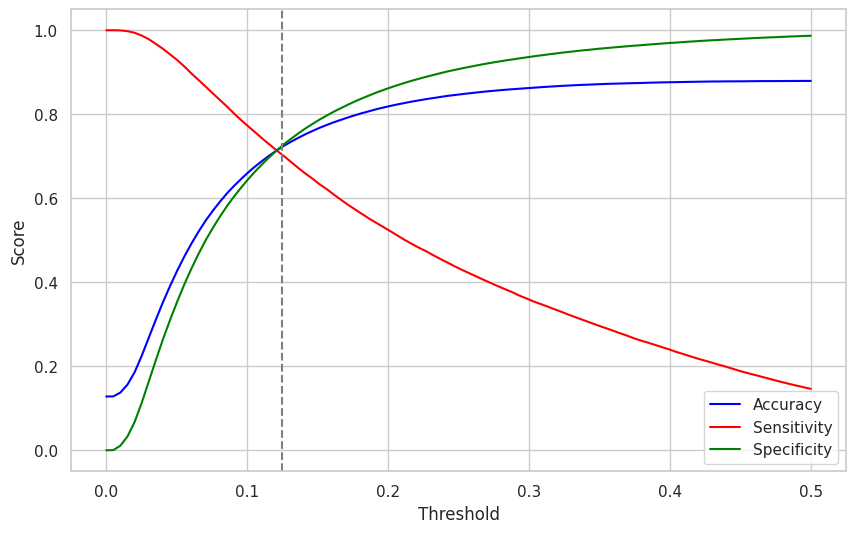

In [129]:
cutoffs = np.linspace(0, 0.5, 100)
results = []

for cutoff in cutoffs:
    valid_predict_xgboost = xgb_model.predict(valid_DMatrix)
    valid_predict_xgboost = [1 if prob >= cutoff else 0 for prob in valid_predict_xgboost]
    
    accuracy = accuracy_score(valid_DF['reordered'], valid_predict_xgboost)
    tn, fp, fn, tp = confusion_matrix(valid_DF['reordered'], valid_predict_xgboost).ravel()
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    results.append([cutoff, accuracy, sensitivity, specificity])

results_df = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'Sensitivity', 'Specificity'])

# Plotting
plt.figure(figsize=(10,6))
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', color='blue')
plt.plot(results_df['Threshold'], results_df['Sensitivity'], label='Sensitivity', color='red')
plt.plot(results_df['Threshold'], results_df['Specificity'], label='Specificity', color='green')
plt.axvline(x=0.125, linestyle='--', color='gray')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


In [130]:
# 예측 수행
valid_predict_xgboost = xgb_model.predict(valid_DMatrix)

# 임계값 0.125를 기준으로 이진 분류 수행
valid_predict_xgboost = [1 if pred >= 0.125 else 0 for pred in valid_predict_xgboost]

# 오차 행렬 생성
conf_matrix = confusion_matrix(valid_DF['reordered'], valid_predict_xgboost)
class_report = classification_report(valid_DF['reordered'], valid_predict_xgboost, target_names=["0", "1"])

print(conf_matrix)
print(class_report)

[[269220 101896]
 [ 16158  38283]]
              precision    recall  f1-score   support

           0       0.94      0.73      0.82    371116
           1       0.27      0.70      0.39     54441

    accuracy                           0.72    425557
   macro avg       0.61      0.71      0.61    425557
weighted avg       0.86      0.72      0.77    425557



In [131]:
# 예측 수행
test_DF['reordered'] = xgb_model.predict(test_DMatrix)

# 임계값 0.125를 기준으로 이진 분류 수행
test_DF['reordered'] = (test_DF['reordered'] > 0.125).astype(int)


In [132]:

# Filter rows where reordered is 1
filtered = test_DF[test_DF['reordered'] == 1]

# Group by order_id and concatenate product_id as string
submission = filtered.groupby('order_id')['product_id'].apply(lambda x: ' '.join(map(str, x))).reset_index()
submission.columns = ['order_id', 'products']

# Find missing order_id and add them with products as 'None'
missing_order_ids = set(test_DF['order_id']) - set(submission['order_id'])
missing = pd.DataFrame({'order_id': list(missing_order_ids), 'products': 'None'})

# Concatenate submission and missing dataframes and sort by order_id
submission = pd.concat([submission, missing], ignore_index=True).sort_values(by='order_id')


submission.head()  # Displaying first few rows for verification

order_id                                           products
0        17          47766 39275 21709 38777 21463 26429 13107
1        34                            47766 39180 47029 30639
2       137  41787 24852 21903 29594 18465 44422 5134 34126...
3       182  13176 35951 47209 21903 30391 39275 13629 2710...
4       257  49235 24852 37646 47766 21137 22035 24838 2710...